In [1]:
import math
import os
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal ,AutoDelta
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve
from torch.distributions.transforms import TanhTransform
%matplotlib inline
smoke_test = ('CI' in os.environ)

In [2]:
# read CSV file
file_path = 'SMM_preprocessed.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)
df = df.sort_values(by='Time')
df.head()

,Time,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
1012,2020-01-02,2.122,164570.0,61.18,486870.0,2.8250,72460.0,6967.0,632780,986.90,...,342261.0,410,329.81,4350000,94.90,80720000,209.78,12090000,1528.1,270550.0
1011,2020-01-03,2.130,144670.0,63.05,885860.0,2.7870,74750.0,7343.1,936290,988.55,...,339155.0,220,325.90,3800000,93.75,75330000,208.67,11200000,1552.4,436740.0
1010,2020-01-06,2.135,154680.0,63.27,724240.0,2.7900,59570.0,7759.1,786750,969.35,...,340210.0,280,335.83,5670000,95.14,81310000,212.60,17070000,1568.8,558970.0
1009,2020-01-07,2.162,163010.0,62.70,582650.0,2.7935,59470.0,8155.7,1010000,977.75,...,338901.0,280,330.75,4740000,95.34,82680000,213.06,15110000,1574.3,435870.0
1008,2020-01-08,2.141,242560.0,59.61,1210000.0,2.8120,77700.0,8059.6,1190000,961.00,...,339188.0,190,339.26,7110000,94.60,70240000,215.22,13490000,1560.2,813410.0


In [3]:
# Define the price columns
price_columns = [col for col in df.columns if col.endswith('_Price')]

# Loop through each price column and calculate log(price(t) / price(t-1))
for col in price_columns:
    # Calculate log returns
    log_returns = np.log(df[col] / df[col].shift(1))
    
    # Pad with a zero at the beginning (to keep the same length as the 'Time' column)
    log_returns = log_returns.fillna(0)
    
    # Create the new column name by replacing '_Price' with '_Volatility'
    volatility_col = col.replace('_Price', '_Volatility')
    
    # Add the new column to the DataFrame
    df[volatility_col] = log_returns


/home/arataz/NDE/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


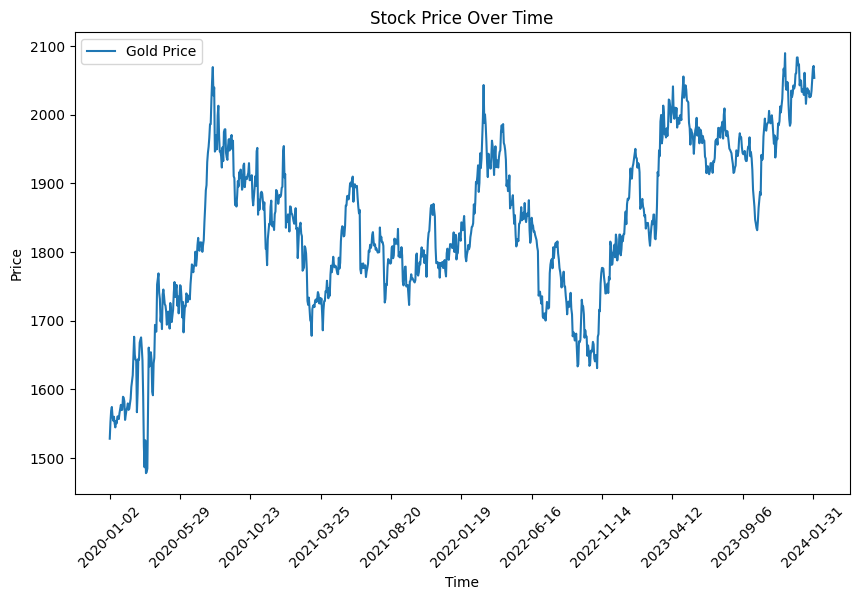

In [4]:
# Select the column for Gold Price & volatillity
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(df)), df['Gold_Price'], label='Gold Price')# Add labels, title, and legend
ax.set_xlabel('Time')
n = max(len(df) // 10, 1)  # Show about 10 ticks
ax.set_xticks(range(0, len(df), n))
ax.set_xticklabels(df['Time'][::n], rotation=45)
ax.set_ylabel('Price')
ax.set_title('Stock Price Over Time')
ax.legend()
plt.show()

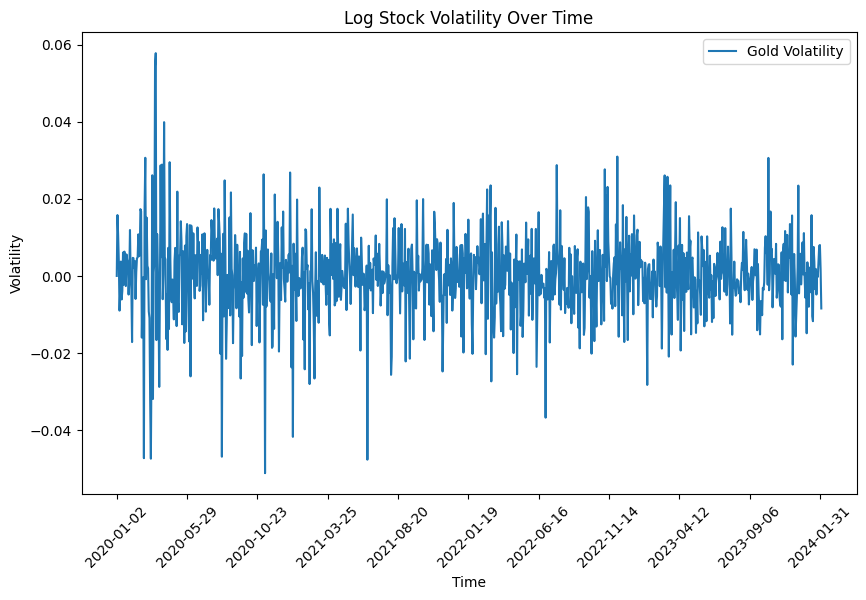

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(df)), df['Gold_Volatility'], label='Gold Volatility')# Add labels, title, and legend
ax.set_xlabel('Time')
n = max(len(df) // 10, 1)  # Show about 10 ticks
ax.set_xticks(range(0, len(df), n))
ax.set_xticklabels(df['Time'][::n], rotation=45)
ax.set_ylabel('Volatility')
ax.set_title('Log Stock Volatility Over Time')
ax.legend()
plt.show()

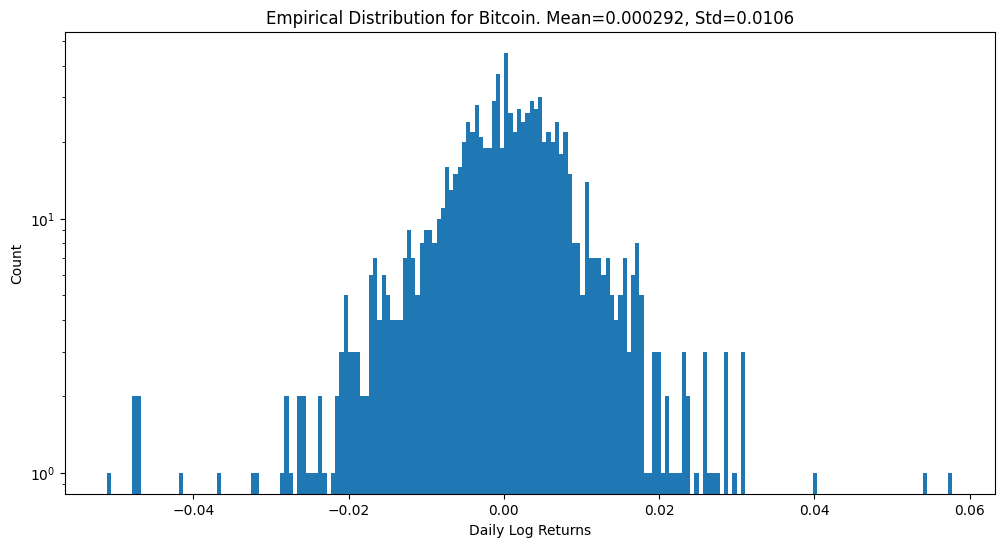

In [6]:
dates = df['Time'].to_numpy()
r = df['Gold_Volatility'].to_numpy()
r = torch.tensor(r).float()

# Histogram of daily log returns
plt.figure(figsize=(12, 6))
plt.hist(r.numpy(), bins=200)
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Daily Log Returns")
plt.title("Empirical Distribution for Bitcoin. Mean={:0.3g}, Std={:0.3g}".format(r.mean(), r.std()))
plt.show()

In [7]:
r = torch.from_numpy(df['Gold_Volatility'].values)
r_train = torch.from_numpy(df['Gold_Volatility'].values[:-200])
p_train = torch.from_numpy(df['Gold_Price'].values[:-201]).float()
r_test = torch.from_numpy(df['Gold_Volatility'].values[-200:])
p_test = torch.from_numpy(df['Gold_Price'].values[-201:]).float()

In [8]:
def model(r):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(r.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h, validate_args= False).to_event(1),
                obs=r)

reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})    

step 0 loss = 21.7003
step 100 loss = -1.80898
step 200 loss = -2.60665
step 300 loss = -2.63063
step 400 loss = -2.83491
step 500 loss = -2.91014
step 600 loss = -2.83718
step 700 loss = -2.89064
CPU times: user 9.1 s, sys: 187 ms, total: 9.29 s
Wall time: 9.37 s


(-2.95334308493271, 20.0)

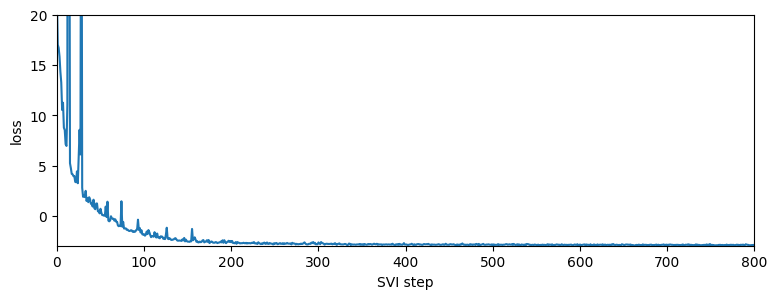

In [9]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(42)

def fit_model(model):
    num_steps = 1 if smoke_test else 800
    optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
    guide = AutoDiagonalNormal(model)
    svi = SVI(model, guide, optim, Trace_ELBO())
    num_samples = 200
    losses = []
    stats = []
    log_vol = []
    for step in range(num_steps):
        loss = svi.step(r) / len(r)
        losses.append(loss)
        stats.append(guide.quantiles([0.325, 0.675]).items())
        if step % 100 == 0:
            print("step {} loss = {:0.6g}".format(step, loss))

    return guide, losses, stats, log_vol

guide, losses, stats, log_vol = fit_model(reparam_model)

plt.figure(figsize=(9, 3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("SVI step")
plt.xlim(0, len(losses))
plt.ylim(min(losses), 20)

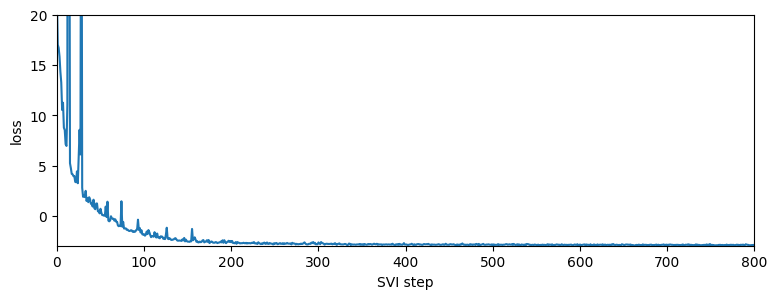

--------------------
h_0 = -0.9157 ± 0.02287
r_loc = -0.006912 ± 0.004601
r_skew = 0.02366 ± 0.003673
r_stability = 1.939 ± 0.006898
sigma = 0.4641 ± 0.001003


In [10]:
plt.figure(figsize=(9, 3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("SVI step")
plt.xlim(0, len(losses))
plt.ylim(min(losses), 20)
plt.show()
print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

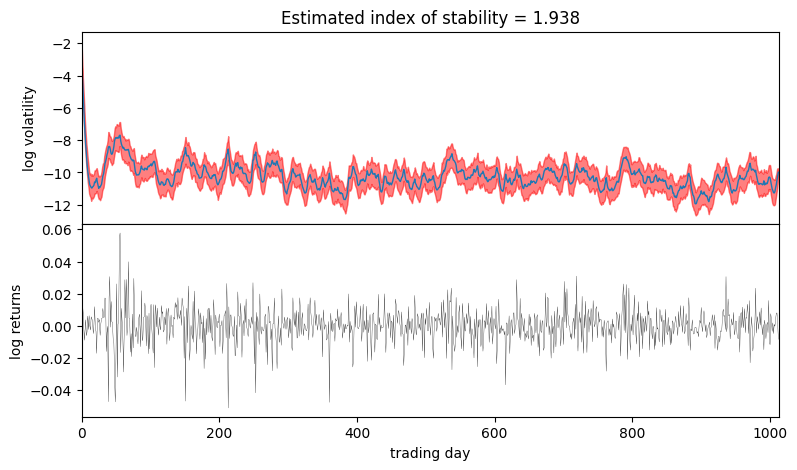

In [11]:
fig, axes = plt.subplots(2, figsize=(9, 5), sharex=True)
plt.subplots_adjust(hspace=0)
axes[1].plot(r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
num_samples = 200
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=num_samples, parallel=True)(r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1)
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(int(num_samples * 0.1), dim=0).values,
                     log_h.kthvalue(int(num_samples * 0.9), dim=0).values,
                     color='red', alpha=0.5)
axes[0].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[1].set_xlabel("trading day");

In [12]:
class vParamNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(vParamNet, self).__init__()
        
        # Define fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_loc = nn.Linear(hidden_dim, 1)  # Output for loc (mean)
        self.fc2_scale = nn.Linear(hidden_dim, 1)  # Output for scale (stddev)
        
        # Optional: Initialize weights (you can also rely on the default initialization)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.xavier_normal_(self.fc2_loc.weight)
        nn.init.xavier_normal_(self.fc2_scale.weight)

    def forward(self, x):
        # Pass input through the first hidden layer with ReLU activation
        hidden = F.relu(self.fc1(x))
        
        # Output loc (mean) directly from fc2_loc
        loc = self.fc2_loc(hidden)
        
        # Output scale from fc2_scale, passed through Softplus to ensure positivity
        scale = F.softplus(self.fc2_scale(hidden))
        
        return loc, scale
class GatedTransition(nn.Module):
    """
    Parameterizes the gaussian latent transition probability p(z_t | z_{t-1})
    See section 5 in the reference for comparison.
    """
    def __init__(self, input_dim, transition_dim):
        super().__init__()
        # initialize the six linear transformations used in the neural network
        self.lin_gate_z_to_hidden = nn.Linear(input_dim, transition_dim)
        self.lin_gate_hidden_to_z = nn.Linear(transition_dim, input_dim)
        self.lin_proposed_mean_z_to_hidden = nn.Linear(input_dim, transition_dim)
        self.lin_proposed_mean_hidden_to_z = nn.Linear(transition_dim, input_dim)
        self.lin_z_to_loc = nn.Linear(input_dim, input_dim)
        # modify the default initialization of lin_z_to_loc
        # so that it's starts out as the identity function
        self.lin_z_to_loc.weight.data = torch.eye(input_dim)
        self.lin_z_to_loc.bias.data = torch.zeros(input_dim)
        # initialize the three non-linearities used in the neural network
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softplus = nn.Softplus()

    def forward(self, x):
        """
        Given the latent z_{t-1} corresponding to the time step t-1
        we return the mean and scale vectors that parameterize the
        (diagonal) gaussian distribution p(z_t | z_{t-1})
        """
        # compute the gating function
        _gate = self.relu(self.lin_gate_z_to_hidden(x))
        gate = self.sigmoid(self.lin_gate_hidden_to_z(_gate))
        # compute the 'proposed mean'
        _proposed_mean = self.relu(self.lin_proposed_mean_z_to_hidden(x))
        proposed_mean = self.lin_proposed_mean_hidden_to_z(_proposed_mean)
        # assemble the actual mean used to sample z_t, which mixes
        # a linear transformation of z_{t-1} with the proposed mean
        # modulated by the gating function
        loc = (1 - gate) * self.lin_z_to_loc(x) + gate * proposed_mean
        # compute the scale used to sample z_t, using the proposed
        # return loc which can be fed into Normal
        return loc

In [13]:
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
priors = list(guide.median(0).values())
class Predict_Price(ForecastingModel):
    def __init__(self, priors):
        super().__init__()
        self.priors = priors
        self.g = vParamNet(input_dim = 1, hidden_dim = 16)
        self.f = GatedTransition(input_dim = 1, transition_dim= 16)
    def model(self, zero_data,covariates):
        p = covariates[:,0]
        t = covariates[:,1]
        # Note we avoid plates because we'll later reparameterize along the time axis using
        # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
        h_0 = pyro.sample("h_0", dist.Normal(self.priors[0], 0.01)).unsqueeze(-1)
        sigma = pyro.sample("sigma", dist.LogNormal(self.priors[1], 0.01)).unsqueeze(-1)
        r_loc = pyro.sample("r_loc", dist.Normal(self.priors[3], 1e-2)).unsqueeze(-1)
        r_skew = pyro.sample("r_skew", dist.Uniform(self.priors[4]-1e-2, self.priors[4]+1e-2)).unsqueeze(-1)
        r_stability = pyro.sample("r_stability", dist.Uniform(self.priors[5]-1e-2, self.priors[5]-1e-3)).unsqueeze(-1)
        with pyro.plate("batch", len(p)), poutine.scale(scale=1/ len(p)):
            with poutine.reparam(config={"v": DiscreteCosineReparam()}):
                v = pyro.sample("v", dist.Normal(self.g(p.reshape(-1,1))[0], self.g(p.reshape(-1,1))[1]).to_event(1))
            log_h = pyro.deterministic("log_h", h_0 + sigma * v.squeeze(-1)* (torch.sqrt(t))).unsqueeze(-1)
            sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)
            with poutine.reparam(config={"r": StableReparam()}):
                r = pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h, validate_args= False).to_event(1))

        pred = self.f(p.reshape(-1,1)) + r
        pred = pred.exp()
        pyro.deterministic("prediction", pred)
        noise_dist = dist.Normal(0, 1)
        self.predict(noise_dist, pred)
    


In [14]:
def predict(params, num_samples = 1000):
    from pyro.ops.stats import quantile
    h_0 = params[2]
    sigma = params[3]
    r_loc = params[4]
    r_skew = params[5]
    r_stability = params[6]
    num_samples = 1000
    indices = t%3 ==0
    p0 = p_train[indices]
    pred_samples = torch.zeros((num_samples, len(p_train)))
    for i in range(1,4):
        for j in range(num_samples):
            with torch.no_grad():
                v = pyro.sample("v", dist.Normal(model.g(p0.reshape(-1,1))[0], model.g(p0.reshape(-1,1))[1]).to_event(1)).squeeze(-1)
                log_h = pyro.deterministic("log_h", h_0 + sigma * v* (torch.sqrt(t[indices])))
                sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)
                r = pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h, validate_args= False).to_event(1))
                pred = model.f(p0.reshape(-1,1)).squeeze(-1)
                pred = pred.exp() + r
                pred_samples[j,indices] = pred
        p10, p50, p90 = quantile(pred_samples[:,indices], (0.1, 0.5, 0.9)).squeeze(-1)
        p0 = p50.log()
        if i ==1:
            p0 = p0[:-1]
        indices = (t-i)%3 ==0
    p10, p50, p90 = quantile(pred_samples, (0.25, 0.5, 0.75)).squeeze(-1)
    error = np.abs(p50-p_response.squeeze(-1))/p_response.squeeze(-1)*100
    error = error[t%3!=0]
    train_error = torch.mean(error[:-130])
    val_error = torch.mean(error[-130:])
    with torch.no_grad():
        _gate = model.f.relu(model.f.lin_gate_z_to_hidden(p_train.unsqueeze(-1)))
        gate = model.f.sigmoid(model.f.lin_gate_hidden_to_z(_gate))
    return p10, p50, p90, train_error, val_error, gate

In [15]:
pyro.clear_param_store()
pyro.set_rng_seed(42)
p_response = torch.from_numpy(df['Gold_Price'].values[1:]).float().reshape(-1,1)
p_train = torch.from_numpy(np.log(df['Gold_Price'].values[:-1])).float()
t = torch.range(0,len(p_train)-1, 1)
covariates = torch.stack((p_train,t),dim = 1)
# start, train end, test end
n = len(df)
T0 = 0
T1 = n - 200
T2 = n
num_steps = 601
p10_list = []
p50_list= []
p90_list = []
val_errors = []
train_errors = []
gates = []
pyro.clear_param_store()
pyro.set_rng_seed(42)
model = Predict_Price(priors)
forecaster = Forecaster(
    model,
    p_response[:T1],
    covariates[:T1],
    # guide = AutoDelta(model.model),
    learning_rate=0.01,
    learning_rate_decay=0.05,
    num_steps=num_steps,
    log_every=100
)

/tmp/ipykernel_156871/3850507739.py:5: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  t = torch.range(0,len(p_train)-1, 1)
INFO 	 step    0 loss = 3.19993e+10
INFO 	 step  100 loss = 7.64975e+09
INFO 	 step  200 loss = 1.91106e+09
INFO 	 step  300 loss = 3.35206e+08
INFO 	 step  400 loss = 8.70288e+07
INFO 	 step  500 loss = 484956
INFO 	 step  600 loss = 8825.4


In [16]:
pyro.set_rng_seed(42)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(p_response[:T1], covariates[:T1], num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

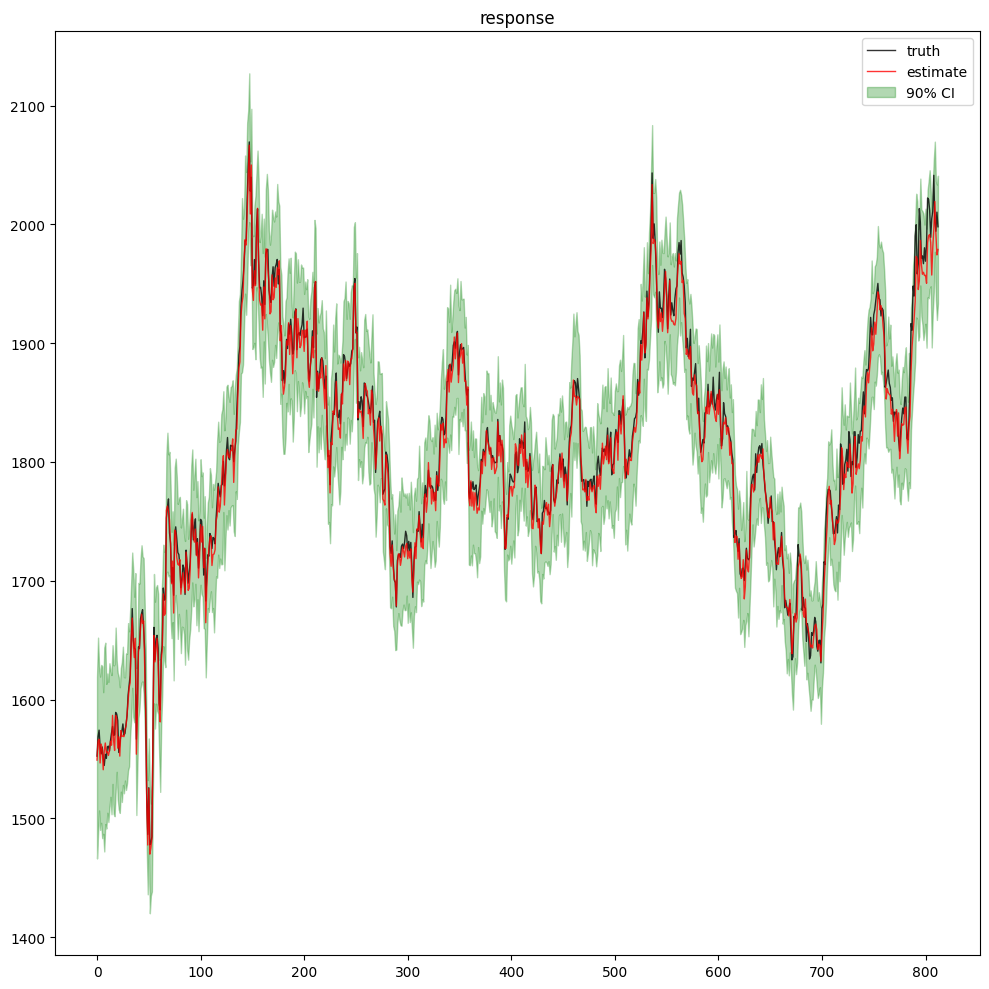

In [17]:
from pyro.ops.stats import quantile

# overlay estimations with truth
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
r_p10, r_p50, r_p90 = quantile(posterior_samples['r'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
axes.plot(p_response[:T1], 'k-', label='truth', alpha=.8, lw=1)
axes.plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
axes.fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="green", alpha=.3, label = '90% CI')
axes.legend()
axes.set_title('response')
plt.tight_layout()

In [18]:
params = []
for key in posterior_samples.keys():
    lb , p50, ub = quantile(posterior_samples[key], (0.1,0.5, 0.9)).squeeze(-1)
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        params.append(p50)
        print("{} = {:0.4g} ± {:0.4g}".format(key, p50, (ub - lb) / 2))

particles = 0 ± 0
time = 0 ± 0
h_0 = 0.9755 ± 0.1445
sigma = 0.2431 ± 0.02376
r_loc = 0.03715 ± 0.07735
r_skew = 0.01473 ± 0.0001245
r_stability = 1.931 ± 0.0001252
batch = 0 ± 0


In [21]:
# Let's run a test where we try to predict windows of length 5
# our input data would be
# n_pred_day = [i for i in range(2,14)]
n_pred_day = [i for i in range(2,12)]

day_out = [0,1,0,2,4,4,4,4,2,0,4,11]
h_0 = params[2]
sigma = params[3]
r_loc = params[4]
r_skew = params[5]
r_stability = params[6]
num_samples = 1000
errors = []
for n_pred_days in n_pred_day:
    
    print('n:', n_pred_days)
    indices = t%n_pred_days ==0
    p0 = p_train[indices]
    pred_samples = torch.zeros((num_samples, len(p_train)))
    for i in range(1,n_pred_days + 1):
        for j in range(num_samples):
            with torch.no_grad():
                v = pyro.sample("v", dist.Normal(model.g(p0.reshape(-1,1))[0], model.g(p0.reshape(-1,1))[1]).to_event(1)).squeeze(-1)
                log_h = pyro.deterministic("log_h", h_0 + sigma * v* (torch.sqrt(t[indices])))
                sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)
                r = pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h, validate_args= False).to_event(1))
                pred = model.f(p0.reshape(-1,1)).squeeze(-1)
                pred = pred.exp() + r
                pred_samples[j,indices] = pred
        p10, p50, p90 = quantile(pred_samples[:,indices], (0.1, 0.5, 0.9)).squeeze(-1)
        p0 = p50.log()
        if i ==day_out[n_pred_days - 2]:
            p0 = p0[:-1]
        indices = (t-i)%n_pred_days ==0
        print(i)
    indices = t%n_pred_days ==0
    p10, p50, p90 = quantile(pred_samples, (0.25, 0.5, 0.75)).squeeze(-1)
    error = torch.mean(np.abs(p50 - p_response.squeeze(-1))/p_response.squeeze(-1))
    errors.append(error*100)




n: 2
1
2
n: 3
1
2
3
n: 4
1
2
3
4
n: 5
1
2
3
4
5
n: 6
1
2
3
4
5
6
n: 7
1
2
3
4
5
6
7
n: 8
1
2
3
4
5
6
7
8
n: 9
1
2
3
4
5
6
7
8
9
n: 10
1
2
3
4
5
6
7
8
9
10
n: 11
1
2
3
4
5
6
7
8
9
10
11


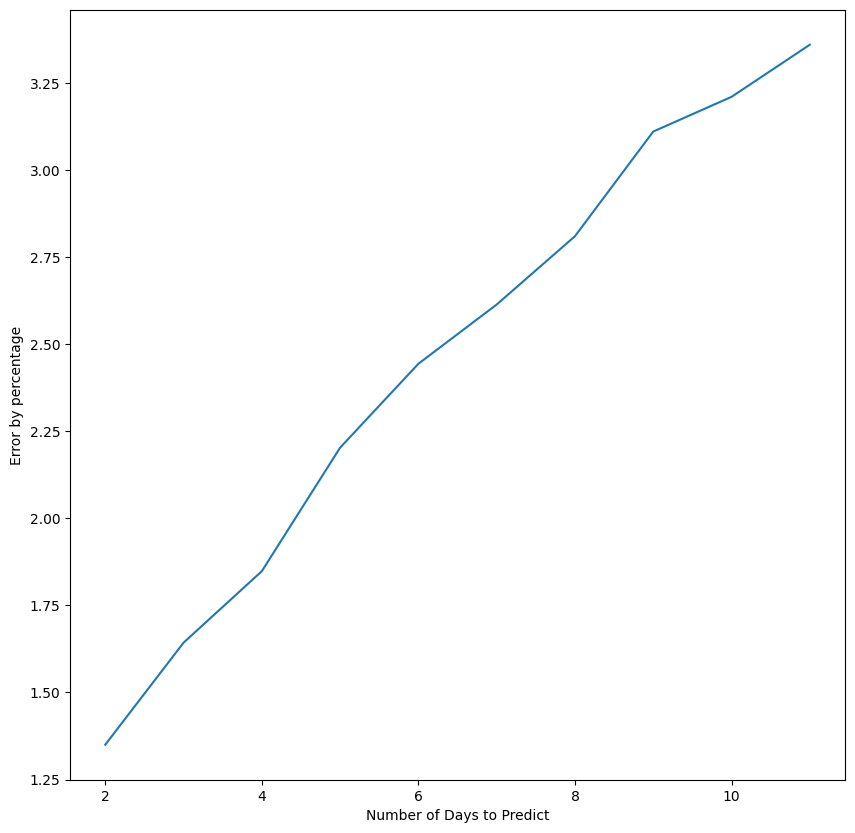

In [22]:
plt.figure(figsize= (10,10))
plt.plot(torch.arange(2,len(errors)+2),errors)
plt.xlabel('Number of Days to Predict')
plt.ylabel('Error by percentage')
plt.show()

In [25]:
pred_samples.shape

torch.Size([1000, 1012])

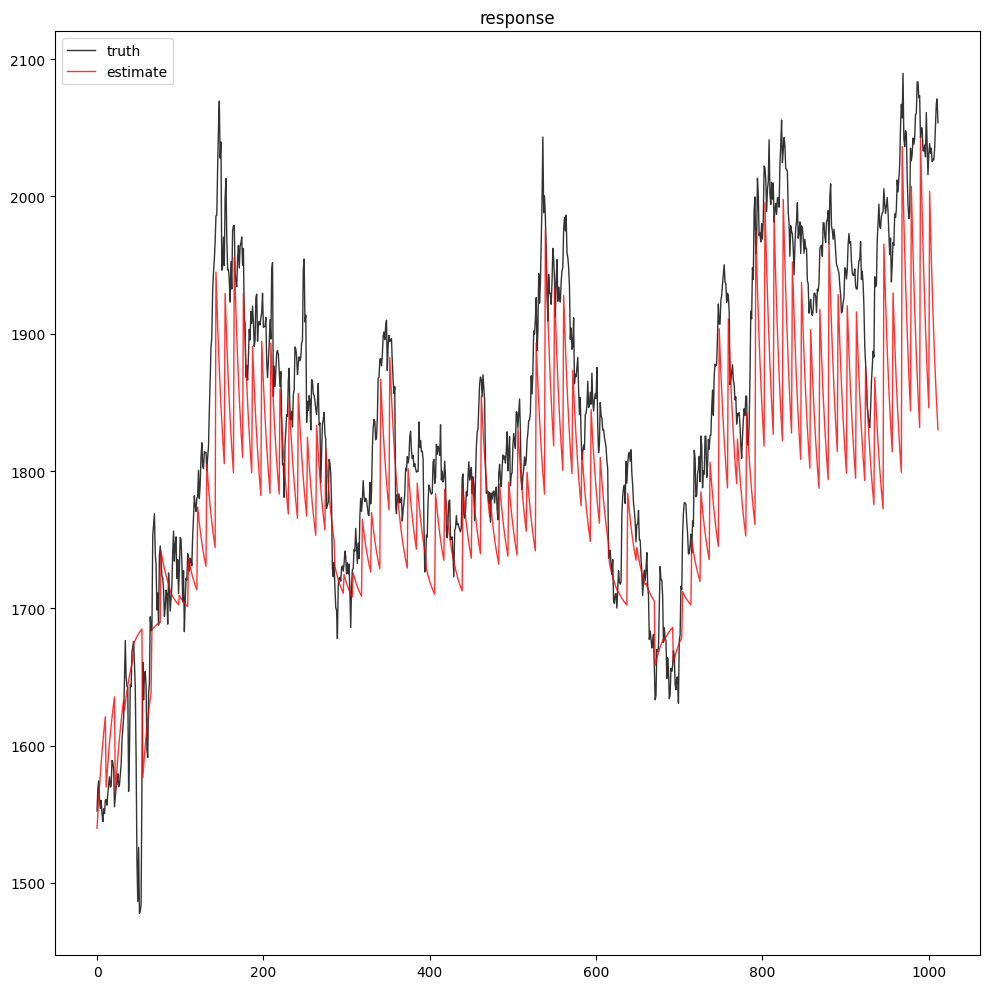

In [31]:
# overlay estimations with truth
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
pred_p10, pred_p50, pred_p90 = quantile(pred_samples, (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
axes.plot(p_response, 'k-', label='truth', alpha=.8, lw=1)
axes.plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
axes.legend()
axes.set_title('response')
plt.tight_layout()